In [ ]:
# проверяется гипотеза о наличии у пользователей предпочтений в покупках (склонность к покупкам товаров одного бренда)
# критерий - если пользователь совершил n покупок, то из них какая то часть должна быть одного бренда

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/383523/lesson_3_data__1_.csv', 
                 encoding='windows-1251',
                 usecols=[i for i in range(1,21)]
                )
df.head(1)

,tk,pl,dia,hs,tc,cta,id_art,id_subsubfam,id_subfam,id_fam,id_famn,id_seccion,id_subagr,id_agr,vta,uni,id_artn,art_sp,fam_sp,fam_en
0,120071109002055793,1,2007/11/09,0.505729,110000761,11000076,21895,101070640100,1010706401,10107064,10107064,10107,101,1,0.68,1.0,21895,MARAVILLA 500 G Store_Brand,PASTA ALIMENTICIA SE,pasta


In [16]:
user_df = df[['tc', 'art_sp']]
user_df = user_df.rename(columns={'tc': 'user_id', 'art_sp':'brand_info'})
user_df.head(2)

,user_id,brand_info
0,110000761,MARAVILLA 500 G Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand


In [37]:
user_df['brand'] = user_df.brand_info.apply(lambda x: x.split(' ')[-1])
user_df.head(2)

,user_id,brand_info,brand
0,110000761,MARAVILLA 500 G Store_Brand,Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand,Store_Brand


In [39]:
user_df['user_id'].nunique(), user_df.shape

(11764, (48129, 3))

In [49]:
users_purchases = user_df.groupby('user_id', as_index=False)\
                    .agg({'brand':'count'})\
                    .rename(columns={'brand': 'purchases'})

users_purchases.head(2)

,user_id,purchases
0,-1236394515,1
1,1031,6


In [43]:
users_purchases['user_id'].nunique(), users_purchases['purchases'].median(), users_purchases.purchases.quantile(0.75)

(11764, 2.0, 5.0)

In [51]:
# будем проводить исследование пользователей, количество покупок котороых превышает 75 перцентиль
users_purchases = users_purchases.loc[users_purchases['purchases'] >= 5]
print(users_purchases.shape)
users_purchases.describe()

(3383, 2)


,user_id,purchases
count,3.383000e+03,3383.000000
mean,6.421500e+07,9.320130
std,1.504830e+08,5.623993
min,1.031000e+03,5.000000
25%,8.871271e+06,6.000000
50%,2.842547e+07,7.000000
75%,8.542964e+07,11.000000
max,1.408810e+09,60.000000


In [69]:
lovely_brand_purchases_df = user_df.groupby(['user_id', 'brand'], as_index=False)\
        .agg({'brand_info': 'count'})\
        .rename(columns={'brand_info':'purchase_count'})\
        .sort_values(['user_id', 'purchase_count'], ascending=[False, False])\
        .groupby(['user_id']).head(1)\
        .rename(columns={'brand': 'lovely_brand', 'purchase_count': 'lovely_brand_purchases'})
lovely_brand_purchases_df.head(3)

,user_id,lovely_brand,lovely_brand_purchases
18187,1408849249,Store_Brand,1
18186,1408840919,Store_Brand,1
18185,1408832719,Brand_4,3


In [76]:
users_unique_brands = user_df.groupby('user_id', as_index=False) \
                        .agg({'brand': pd.Series.nunique}) \
                        .rename(columns={'brand': 'unique_brands'})
users_unique_brands.head()

,user_id,unique_brands
0,-1236394515,1
1,1031,2
2,4241,2
3,17311,1
4,17312,2


In [82]:
loyalty_df = users_purchases.merge(right=users_unique_brands, on='user_id', how='inner')\
                .merge(right=lovely_brand_purchases_df, on='user_id', how='inner')
loyalty_df.head()

,user_id,purchases,unique_brands,lovely_brand,lovely_brand_purchases
0,1031,6,2,Store_Brand,5
1,4241,5,2,Brand_4,3
2,25971,7,2,Store_Brand,5
3,40911,27,5,Brand_4,19
4,45181,5,4,Store_Brand,2


In [84]:
full_loyal_users = loyalty_df[loyalty_df.unique_brands == 1]
full_loyal_users.shape

(911, 5)

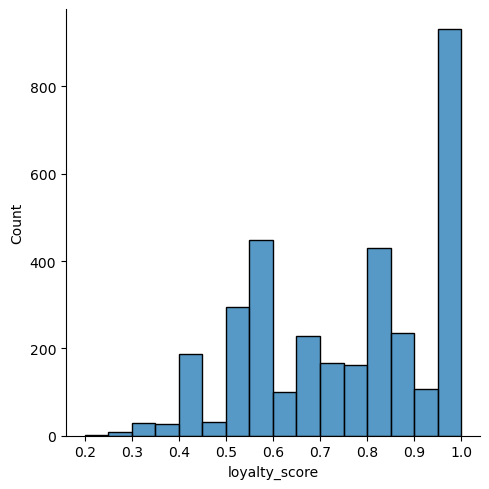

In [94]:
# будем считать пользователя лояльным, если он 
loyalty_df['loyalty_score'] = loyalty_df.lovely_brand_purchases / loyalty_df.purchases
loyalty_df.head()
sns.displot(loyalty_df['loyalty_score'], kde=False);

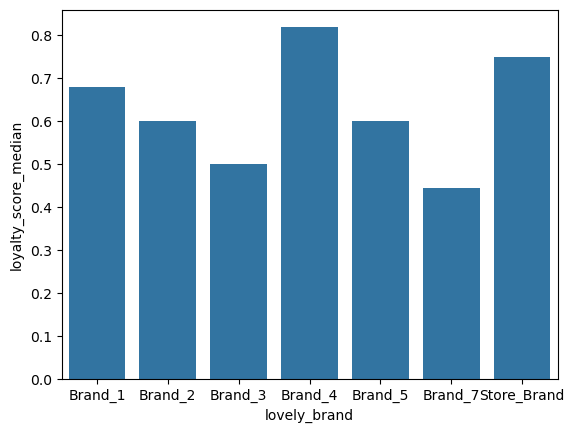

In [108]:
brand_loyalty = loyalty_df.groupby('lovely_brand', as_index=False)\
            .agg({'loyalty_score': 'median', 'user_id': 'count'})\
            .rename(columns={'loyalty_score':'loyalty_score_median', 
                            'user_id':'user_count'})

sns.barplot(data = brand_loyalty, x='lovely_brand', y='loyalty_score_median');

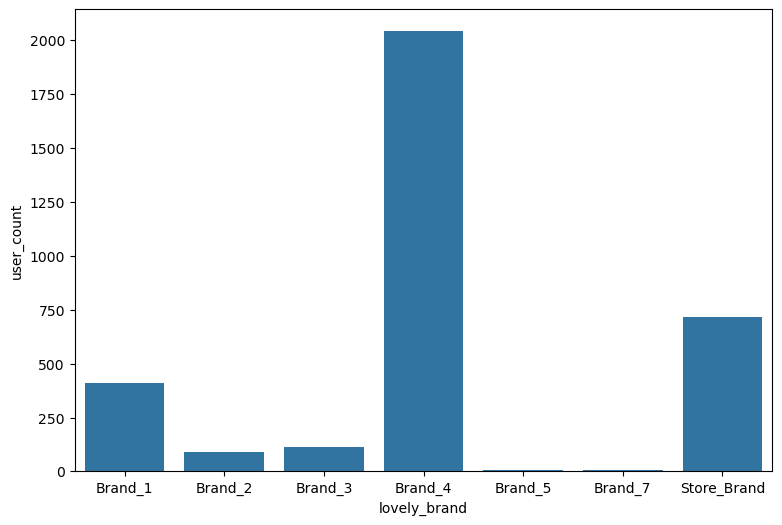

In [107]:
plt.figure(figsize=(9,6))
sns.barplot(data = brand_loyalty, x='lovely_brand', y='user_count');